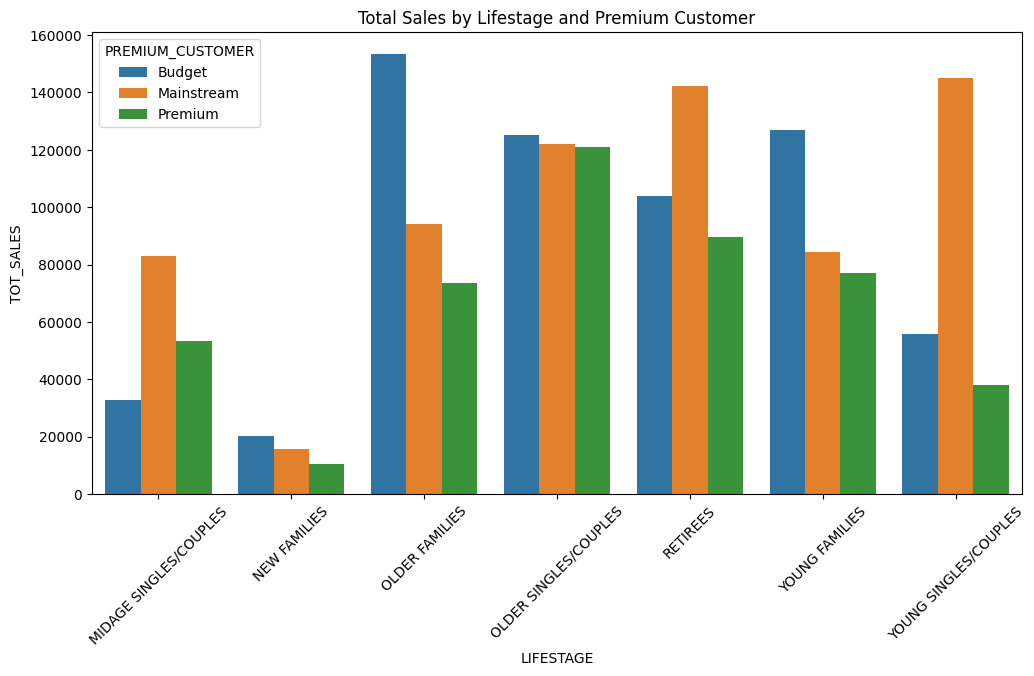

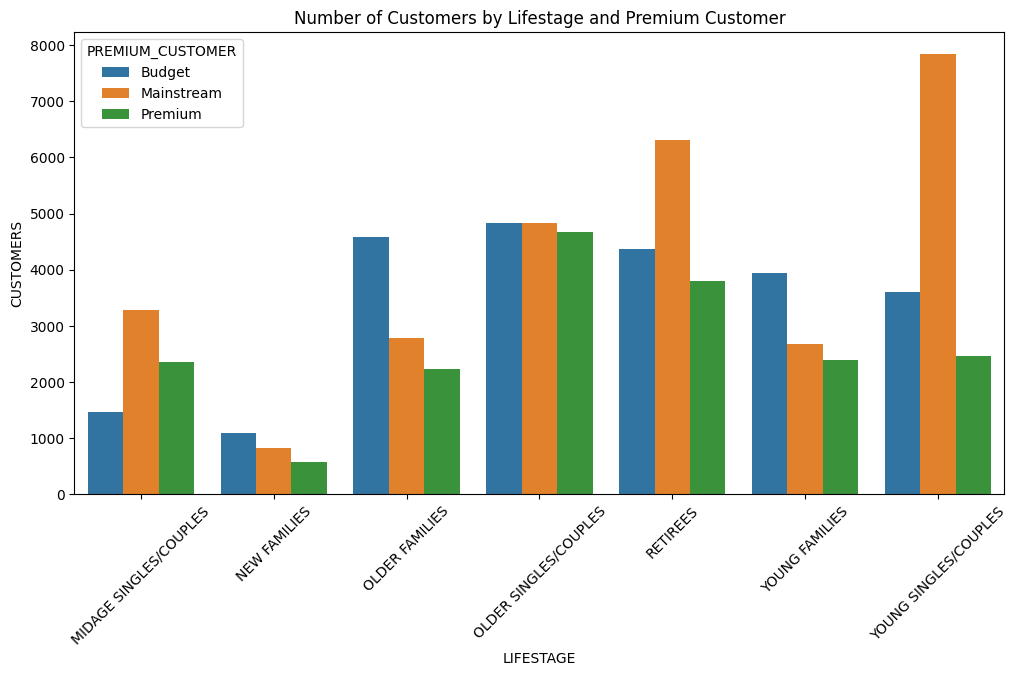

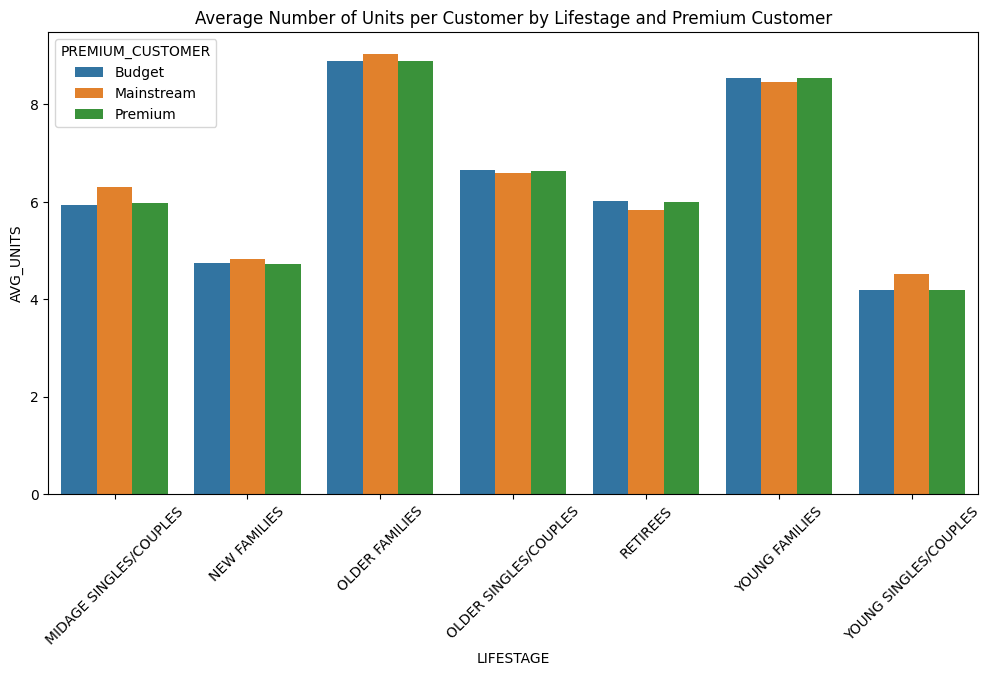

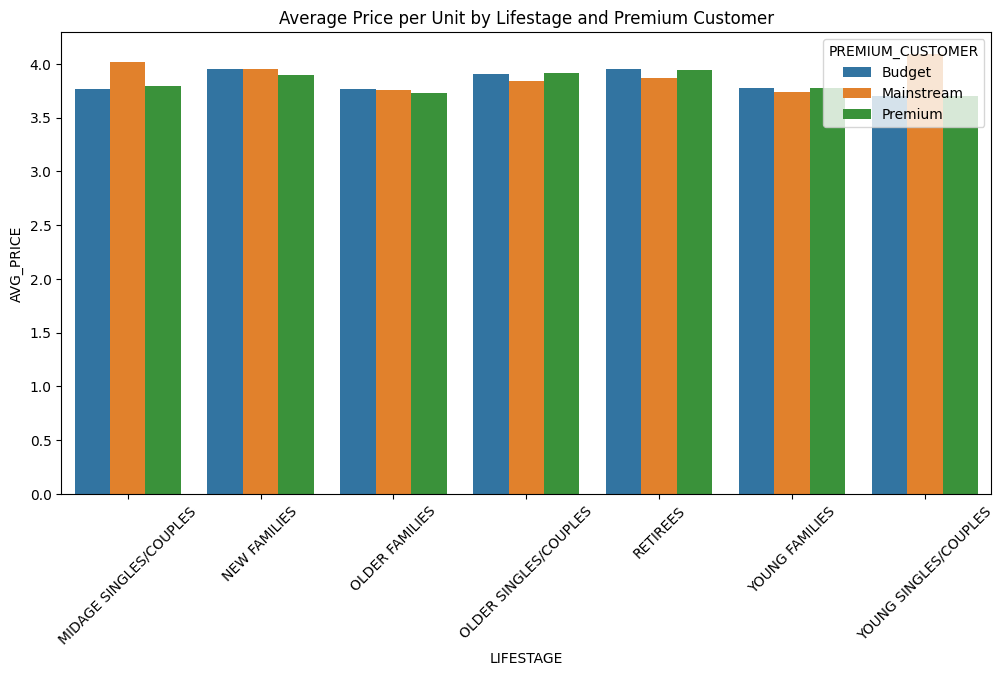

         BRAND  targetSegment     other  affinityToBrand
18    TYRRELLS       0.032234  0.026347         1.223425
17    TWISTIES       0.047180  0.038841         1.214683
5      DORITOS       0.125409  0.103649         1.209934
9       KETTLE       0.202256  0.169771         1.191349
16    TOSTITOS       0.046390  0.038945         1.191166
11    PRINGLES       0.121997  0.103198         1.182158
4         COBS       0.045601  0.040044         1.138777
8    INFUZIONS       0.066074  0.058518         1.129125
15       THINS       0.061675  0.058438         1.055394
7      GRNWVES       0.019459  0.019143         1.016475
3     CHEEZELS       0.018359  0.019122         0.960089
13      SMITHS       0.094952  0.121496         0.781525
6       FRENCH       0.004033  0.005905         0.682963
2      CHEETOS       0.008206  0.012374         0.663201
12         RRD       0.040637  0.062841         0.646674
10     NATURAL       0.020023  0.031640         0.632826
1          CCS       0.011421  

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
transaction_data = pd.read_excel('QVI_transaction_data.xlsx', sheet_name='in')
customer_data = pd.read_csv('QVI_purchase_behaviour.csv')

# Convert DATE column to datetime
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], origin='1899-12-30', unit='D')

# Remove salsa products
transaction_data = transaction_data[~transaction_data['PROD_NAME'].str.contains('salsa', case=False)]

# Identify and remove outlier customers who bought 200 packs of chips in one transaction
outlier_customers = transaction_data[transaction_data['PROD_QTY'] == 200]['LYLTY_CARD_NBR'].unique()
transaction_data = transaction_data[~transaction_data['LYLTY_CARD_NBR'].isin(outlier_customers)]

# Create pack size from PROD_NAME
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract('(\d+)g')
transaction_data = transaction_data.dropna(subset=['PACK_SIZE'])
transaction_data['PACK_SIZE'] = transaction_data['PACK_SIZE'].astype(int)

# Create brand from PROD_NAME
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0].str.upper()

# Clean brand names
brand_mapping = {
    'RED': 'RRD', 'SNBTS': 'SUNBITES', 'INFZNS': 'INFUZIONS', 
    'WW': 'WOOLWORTHS', 'SMITH': 'SMITHS', 'NCC': 'NATURAL', 
    'DORITO': 'DORITOS', 'GRAIN': 'GRNWVES'
}
transaction_data['BRAND'] = transaction_data['BRAND'].replace(brand_mapping)

# Merge transaction data with customer data
data = pd.merge(transaction_data, customer_data, how='left', on='LYLTY_CARD_NBR')

# Ensure no null values in LIFESTAGE and PREMIUM_CUSTOMER
assert data['LIFESTAGE'].isnull().sum() == 0
assert data['PREMIUM_CUSTOMER'].isnull().sum() == 0

# Calculate total sales by LIFESTAGE and PREMIUM_CUSTOMER
sales = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

# Plot total sales
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER', data=sales)
plt.title('Total Sales by Lifestage and Premium Customer')
plt.xticks(rotation=45)
plt.show()

# Number of customers by LIFESTAGE and PREMIUM_CUSTOMER
customers = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index(name='CUSTOMERS')

# Plot number of customers
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='CUSTOMERS', hue='PREMIUM_CUSTOMER', data=customers)
plt.title('Number of Customers by Lifestage and Premium Customer')
plt.xticks(rotation=45)
plt.show()

# Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
avg_units = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({'PROD_QTY': 'sum', 'LYLTY_CARD_NBR': 'nunique'}).reset_index()
avg_units['AVG_UNITS'] = avg_units['PROD_QTY'] / avg_units['LYLTY_CARD_NBR']

# Plot average number of units per customer
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='AVG_UNITS', hue='PREMIUM_CUSTOMER', data=avg_units)
plt.title('Average Number of Units per Customer by Lifestage and Premium Customer')
plt.xticks(rotation=45)
plt.show()

# Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER
avg_price = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({'TOT_SALES': 'sum', 'PROD_QTY': 'sum'}).reset_index()
avg_price['AVG_PRICE'] = avg_price['TOT_SALES'] / avg_price['PROD_QTY']

# Plot average price per unit
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='AVG_PRICE', hue='PREMIUM_CUSTOMER', data=avg_price)
plt.title('Average Price per Unit by Lifestage and Premium Customer')
plt.xticks(rotation=45)
plt.show()

# Deep dive into Mainstream, young singles/couples
segment1 = data[(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream')]
other = data[~((data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream'))]

# Brand affinity compared to the rest of the population
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

quantity_segment1_by_brand = segment1.groupby('BRAND')['PROD_QTY'].sum().reset_index()
quantity_segment1_by_brand['targetSegment'] = quantity_segment1_by_brand['PROD_QTY'] / quantity_segment1

quantity_other_by_brand = other.groupby('BRAND')['PROD_QTY'].sum().reset_index()
quantity_other_by_brand['other'] = quantity_other_by_brand['PROD_QTY'] / quantity_other

brand_proportions = pd.merge(quantity_segment1_by_brand[['BRAND', 'targetSegment']], quantity_other_by_brand[['BRAND', 'other']], on='BRAND')
brand_proportions['affinityToBrand'] = brand_proportions['targetSegment'] / brand_proportions['other']
brand_proportions = brand_proportions.sort_values(by='affinityToBrand', ascending=False)

print(brand_proportions)

# Preferred pack size compared to the rest of the population
quantity_segment1_by_pack = segment1.groupby('PACK_SIZE')['PROD_QTY'].sum().reset_index()
quantity_segment1_by_pack['targetSegment'] = quantity_segment1_by_pack['PROD_QTY'] / quantity_segment1

quantity_other_by_pack = other.groupby('PACK_SIZE')['PROD_QTY'].sum().reset_index()
quantity_other_by_pack['other'] = quantity_other_by_pack['PROD_QTY'] / quantity_other

pack_proportions = pd.merge(quantity_segment1_by_pack[['PACK_SIZE', 'targetSegment']], quantity_other_by_pack[['PACK_SIZE', 'other']], on='PACK_SIZE')
pack_proportions['affinityToPack'] = pack_proportions['targetSegment'] / pack_proportions['other']
pack_proportions = pack_proportions.sort_values(by='affinityToPack', ascending=False)

print(pack_proportions)
